In [25]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib
import matplotlib.cm as cm

In [6]:
def getMaxImg(ops):
    maxImg = ops["max_proj"] # Also "max_proj", "meanImg", "meanImgE"
    mimg = maxImg # Use suite-2p source-code naming
    mimg1 = np.percentile(mimg,1)
    mimg99 = np.percentile(mimg,99)
    mimg = (mimg - mimg1) / (mimg99 - mimg1)
    mimg = np.maximum(0,np.minimum(1,mimg))
    mimg *= 255
    mimg = mimg.astype(np.uint8)
    return mimg

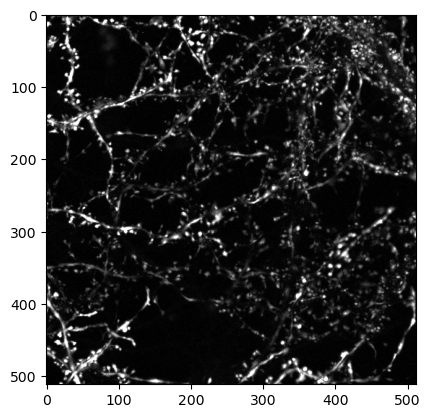

In [11]:
plt.imshow(getMaxImg(ops), cmap='gray')

In [15]:
MaxImg = getMaxImg(ops)
scatters, nid2idx, nid2idx_rejected, pixel2neuron = getStats(stat, MaxImg.shape)

Num cells: 1100
Min/max skew:  -20000 20000


In [18]:
suite2p_path = r'D:\calcium imaging\suite2p_vids\DIV18_cs2_PDBuBase_CNQX_APV_substacks\baseline(1-259)\suite2p\plane0'
ops =  np.load(suite2p_path + '\ops.npy', allow_pickle=True)
ops = ops.item()
stat = np.load(suite2p_path + '\stat.npy', allow_pickle=True)
F = np.load(suite2p_path + '\F.npy', allow_pickle=True)
Fneu = np.load(suite2p_path + '\Fneu.npy', allow_pickle=True)

In [27]:
stat

array([{'ypix': array([502, 502, 503, 503, 503, 503, 504, 504, 504, 504, 504, 504, 505,
              505, 505, 505, 505, 505, 506, 506, 506, 506, 506, 506, 506, 506,
              507, 507, 507, 507, 507, 507, 507, 508, 508, 508, 508, 508, 508,
              508, 509, 509, 509, 509, 509, 509, 509, 509, 510, 510, 510, 510,
              510, 510, 510, 511, 511, 511, 511, 511], dtype=int64), 'lam': array([0.0025151 , 0.00302124, 0.00376835, 0.00694299, 0.00813793,
              0.00350456, 0.0031029 , 0.00787221, 0.01924737, 0.01852822,
              0.00884272, 0.0037823 , 0.00450694, 0.01548836, 0.03936457,
              0.03378934, 0.01582015, 0.00571866, 0.00259919, 0.00736406,
              0.0284459 , 0.05744045, 0.04477435, 0.02067416, 0.00586869,
              0.00203476, 0.00357332, 0.01145774, 0.03969423, 0.06554639,
              0.0480422 , 0.02334211, 0.00678391, 0.00517933, 0.0150593 ,
              0.0439606 , 0.05811954, 0.04495304, 0.02122619, 0.00541474,
              

In [16]:
def getStats(stat, frame_shape):
    MIN_SKEW = 2 #TODO: define for iscell; also figure exclude noncell
    pixel2neuron = np.full(frame_shape, fill_value=np.nan, dtype=float)
    scatters = dict(x=[], y=[], color=[], text=[])
    min_skew, max_skew = -20000, 20000 #swapoped min/max 20,000 *-1
    nid2idx = {}
    nid2idx_rejected = {}
    print(f"Num cells: {stat.shape[0]}")
    from suite2p.gui.utils import boundary
    for n in range(stat.shape[0]):
        skew = stat[n]['skew']
        min_skew, max_skew = min(skew, min_skew), max(skew, max_skew)
        if skew > MIN_SKEW:
            nid2idx[n] = len(scatters["x"]) # Assign new idx
        else:
            nid2idx_rejected[n] = len(scatters["x"])
        ypix = stat[n]['ypix'].flatten() - 1#[~stat[n]['overlap']] - 1
        xpix = stat[n]['xpix'].flatten() - 1#[~stat[n]['overlap']] - 1
        yext, xext = boundary(ypix, xpix)
        scatters['x'] += [xext]
        scatters['y'] += [yext]
        pixel2neuron[xpix, ypix] = n
        scatters["color"].append(skew)
        scatters["text"].append(f"Cell #{n} - Skew: {skew}")
    print("Min/max skew: ", min_skew, max_skew)
    # Normalize colors between 0 and 1
    color_raw = np.array(scatters["color"])
    scatters["color"] = (color_raw - min_skew) / (max_skew - min_skew)
    return scatters, nid2idx, nid2idx_rejected, pixel2neuron


In [21]:
def dispPlot(MaxImg, scatters, nid2idx, nid2idx_rejected,
             pixel2neuron, F, Fneu, axs=None):
  if axs is None:
    fig = plt.figure(constrained_layout=True)
    NUM_GRIDS=12
    gs = fig.add_gridspec(NUM_GRIDS, 1)
    ax1 = fig.add_subplot(gs[:NUM_GRIDS-2])
    ax2 = fig.add_subplot(gs[NUM_GRIDS-2])
    fig.set_size_inches(6,7)
  else:
    ax1 = axs
    ax1.set_xlim(0, MaxImg.shape[0])
    ax1.set_ylim(MaxImg.shape[1], 0)
    ax2 = None
  ax1.imshow(MaxImg, cmap='gray')
  #fig.update_xaxes(showticklabels=False)
  #fig.update_yaxes(showticklabels=False)
  print("Neurons count:", len(nid2idx))
  norm = matplotlib.colors.Normalize(vmin=0, vmax=1, clip=True)
  mapper = cm.ScalarMappable(norm=norm, cmap=cm.viridis)

Neurons count: 1052


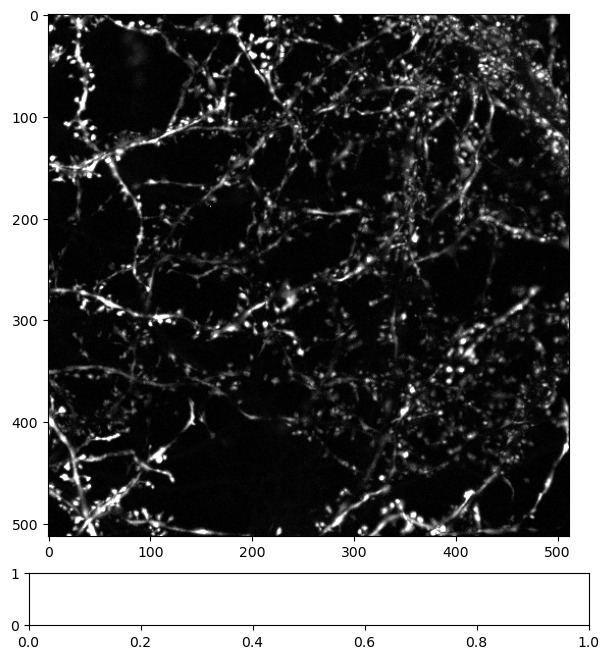

In [26]:
dispPlot(getMaxImg(ops),scatters, nid2idx, nid2idx_rejected, pixel2neuron, F, Fneu)

In [3]:
def plot_composite_fov(footprints, colormap='gist_rainbow', ax = None,label_idx=[],label='milk',highlight=False):
    '''
    Plots all footprints on a single composite field of view.
   
    Args:
        footprints (array):
            n_cells x rows x columns array of footprints
        colormap (str, optional)
            Colormap to use. Each cell will be assigned a random color from this map (defaults to 'gist_rainbow').
    Returns:
        tuple of fig, ax
            fig = matplotlib figure handle
            ax = matplotlib axis handle
    '''
   
    # fig, ax = plt.subplots(figsize=(6,6))
   
    # start with an array of zeros
    composite_fov = np.zeros((footprints.shape[1], footprints.shape[2], 3))
    cmap_vals = cm.get_cmap(colormap)
   
    np.random.seed(0)

    for cell_id in range(footprints.shape[0]):
        # select a random color for this cell
        color = cmap_vals(np.random.rand())

        if cell_id not in label_idx:
          # only label red channel
        #   for color_channel in range(3):
        #     if color_channel == 0:
        #       composite_fov[:,:,color_channel] += color[color_channel]*footprints[cell_id]/np.max(footprints[cell_id])
        #     else:
        #       composite_fov[:,:,color_channel] -= color[color_channel]*footprints[cell_id]/np.max(footprints[cell_id])
        # else:
          # assign the color to each of the three channels, normalized by the footprint peak
            for color_channel in range(3):
                  composite_fov[:,:,color_channel] += color[color_channel]*footprints[cell_id]/np.max(footprints[cell_id])
        # set all values > 1 (where cells overlap) to 1:
    composite_fov[np.where(composite_fov > 1)] = 1
    composite_fov[np.where(composite_fov > 0)] = 0.25 # make it half bright

    ## Do it again but make the label ROI to black (0) first before plotting
    for cell_id in range(footprints.shape[0]):
        # select a random color for this cell
        color = cmap_vals(np.random.rand())
        if not highlight:
            if cell_id in label_idx:
              # make ROI background as a negative value so the overlapping parts with other neurons are not getting weird
              for color_channel in range(3):
                composite_fov[:,:,color_channel] -=color[color_channel]*footprints[cell_id]/np.max(footprints[cell_id])
                composite_fov[np.where(composite_fov < 0)] = 0 # make negative value to 0
            for color_channel in range(3):
                if color_channel in [0]:
                    composite_fov[:,:,color_channel] += color[color_channel]*(footprints[cell_id]/np.max(footprints[cell_id])>0)*10000 # make it to extreme value so it's >0.25
                if color_channel in [1]:
                    composite_fov[:,:,color_channel] += color[color_channel]*(footprints[cell_id]/np.max(footprints[cell_id])>0)*10000
        else:
            if cell_id in label_idx:
              # make ROI background as a negative value so the overlapping parts with other neurons are not getting weird
              for color_channel in range(3):
                composite_fov[:,:,color_channel] -=color[color_channel]*footprints[cell_id]/np.max(footprints[cell_id])
                composite_fov[np.where(composite_fov < 0)] = 0 # make negative value to 0
                for color_channel in range(3):
                    if color_channel in [1]:
                        composite_fov[:,:,color_channel] += color[color_channel]*(footprints[cell_id]/np.max(footprints[cell_id])>0)*10000 # make it to extreme value so it's >0.25
                    if color_channel in [2]:
                        composite_fov[:,:,color_channel] += color[color_channel]*(footprints[cell_id]/np.max(footprints[cell_id])>0)*10000

    # set all values > 1 (where cells overlap) to 1:
    composite_fov[np.where(composite_fov > 1)] = 1
    # set all milk neurons ROIs to 1
    composite_fov[np.where(composite_fov > 0.25)] = 1
   
    # show the image
    ax.imshow(composite_fov)
    ax.text(x=footprints.shape[2]*0.97,y=5,s='all neurons n={}'.format(footprints.shape[0]),color='grey',ha='right',va='top',size=16)
    if not highlight:
        ax.text(x=footprints.shape[2]*0.97,y=13,s='{} n={}'.format(label,len(label_idx)),color='yellow',ha='right',va='top',size=16)
    else:
        ax.text(x=footprints.shape[2]*0.97,y=13,s='{} n={}'.format(label,len(label_idx)),color='cyan',ha='right',va='top',size=16)

    fig.tight_layout()
    return ax